# Surface Mass Balance: PCA 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [72]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

Set WD

#### Load KM_L 

In [168]:
df = pd.read_csv(r'..\data\promice\preprocessed\daily\KAN_L.csv', index_col=0)
# This bit to only focus on the time where we see Ice Ablation
df = df[df["Ablation"] == True]
df = df[df['Surface height from combined measurements DELTA'].notna()]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1556 entries, 1 to 5142
Data columns (total 21 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   stid                                             1556 non-null   object 
 1   Datetime                                         1556 non-null   object 
 2   Air pressure (upper boom)                        1556 non-null   float64
 3   Air temperature (upper boom)                     1556 non-null   float64
 4   Relative humidity (upper boom) - corrected       1556 non-null   float64
 5   Specific humidity (upper boom)                   1556 non-null   float64
 6   Wind speed (upper boom)                          1556 non-null   float64
 7   Wind from direction (upper boom)                 1556 non-null   float64
 8   Downwelling shortwave radiation - corrected      1556 non-null   float64
 9   Upwelling shortwave radiation 

## PCA

##### Pre-processing

In [169]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html


# This bit retrieve the indexes for all melting season categories and remove column from df
df['Datetime'] = pd.to_datetime(df['Datetime'])

for category in ['pre', 'beginning', 'middle', 'end']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

#df.drop(columns=['Melting Season'], inplace=True) 
indices_beginning

Int64Index([   1,    2,  273,  274,  275,  276,  277,  278,  279,  280,
            ...
            5030, 5031, 5032, 5033, 5034, 5035, 5036, 5037, 5038, 5039],
           dtype='int64', length=242)

In [172]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

try:
    df = df.drop('Surface height from combined measurements DELTA',axis=1)
    df = df.loc[df['Surface height from combined measurements'].notna()]
except:
    pass

X= df.loc[:, df.columns != "Surface height from combined measurements"] # All features except y
y=df["Surface height from combined measurements"]



# using the train test split function
X_train, X_test,y_train, y_test = train_test_split(X,y,
                                   test_size=0.2, 
                                   shuffle=False)

# This bit to convert all numerical values into the same scale 
num_cols = X.select_dtypes(include=['int64','float64']).columns.to_list()
print(num_cols)
scaler = MinMaxScaler()
scaler = StandardScaler()


X_train[num_cols] = X_train[num_cols].ffill().bfill()
X_test[num_cols] = X_test[num_cols].ffill().bfill()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])


display(X_train)

['Air pressure (upper boom)', 'Air temperature (upper boom)', 'Relative humidity (upper boom) - corrected', 'Specific humidity (upper boom)', 'Wind speed (upper boom)', 'Wind from direction (upper boom)', 'Downwelling shortwave radiation - corrected', 'Upwelling shortwave radiation - corrected', 'Downwelling longwave radiation', 'Upwelling longwave radiation', 'Surface temperature', 'Latent heat flux (upper boom)', 'Sensible heat flux (upper boom)', 'Albedo', 'Cloud cover']


,stid,Datetime,Air pressure (upper boom),Air temperature (upper boom),Relative humidity (upper boom) - corrected,Specific humidity (upper boom),Wind speed (upper boom),Wind from direction (upper boom),Downwelling shortwave radiation - corrected,Upwelling shortwave radiation - corrected,Downwelling longwave radiation,Upwelling longwave radiation,Surface temperature,Latent heat flux (upper boom),Sensible heat flux (upper boom),Albedo,Cloud cover,Ablation,Melting Season
1,KAN_L,2008-09-02 00:00:00+00:00,-0.220380,0.640933,0.504300,1.159955,0.461308,1.405950,-1.633288,-1.734196,1.019842,0.513543,0.405057,1.248647,0.497622,-0.122286,0.810377,True,beginning
2,KAN_L,2008-09-03 00:00:00+00:00,-0.445785,0.185833,0.933130,0.894599,-0.936387,0.849979,-1.434449,-1.555757,1.225396,0.377078,0.405057,0.650458,-0.707039,-0.306874,1.276228,True,beginning
3,KAN_L,2008-09-04 00:00:00+00:00,-0.541151,0.148689,-0.129637,0.062112,-0.614951,0.720155,-0.738927,-0.671987,0.179605,0.284517,0.405057,-0.046451,-0.569937,0.091142,0.139040,True,middle
4,KAN_L,2008-09-05 00:00:00+00:00,-2.381256,0.152637,1.299627,1.237738,-0.970544,0.771639,-1.948577,-2.037227,1.685833,0.470262,0.405057,0.731490,-0.708261,0.169098,1.795540,True,middle
11,KAN_L,2008-09-12 00:00:00+00:00,-1.529109,-1.570396,-0.626538,-1.930878,-1.382443,0.414166,-1.143842,-0.590757,-0.905029,-1.735577,-1.560328,0.012925,-0.918549,2.009695,-0.179517,True,middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4302,KAN_L,2020-06-12 00:00:00+00:00,1.040869,-0.599648,-0.631701,-1.151829,-0.373522,-1.065890,1.254037,1.280550,-0.857490,-0.400883,0.003628,-1.312504,-0.660991,-0.205351,-0.516526,True,beginning
4303,KAN_L,2020-06-13 00:00:00+00:00,-0.886830,-0.208654,-0.589569,-0.590056,-0.690505,-0.593645,0.536020,0.680898,-0.653266,-0.336949,-0.114636,-0.188833,-0.581489,-0.046144,-0.590646,True,beginning
4304,KAN_L,2020-06-14 00:00:00+00:00,-0.423302,-1.174295,1.803916,-0.235592,-1.142193,2.556656,-0.019557,1.521716,1.318851,-0.428632,-0.230317,0.044588,-1.237507,2.769579,1.945357,True,beginning
4305,KAN_L,2020-06-15 00:00:00+00:00,0.460482,-1.487099,0.450885,-1.436309,-1.016623,-0.848049,1.225893,2.878266,-0.386244,-1.603993,-1.456353,-0.398739,-0.956642,1.912787,0.336483,True,beginning


**PCA** (We need to rethink if PCA is useful or not)

------------------------- With Imputation -----------------------------------------------------------------

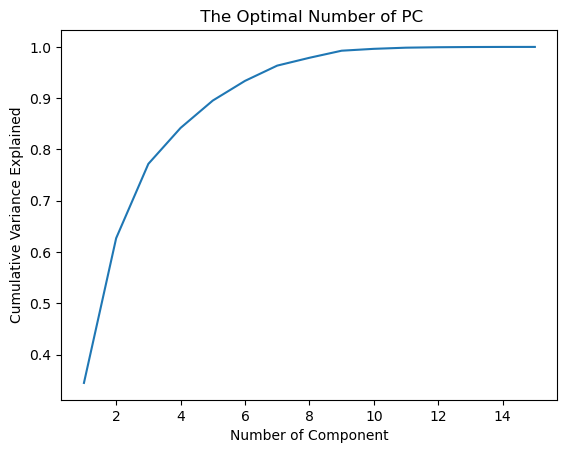

In [173]:
# Apply PCA
from sklearn.decomposition import PCA

pca = PCA()
X_train_imp = pca.fit_transform(X_train[num_cols])
X_test_imp = pca.transform(X_test[num_cols])

# visualizing the amount of variance data explained for each principle component
cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
x_values = list(range(1, len(cumulative_variance_explained)+1))

#plot the line graph explaining variance of feature variables through the components
plt.plot(x_values, cumulative_variance_explained)
plt.xlabel('Number of Component')
plt.ylabel('Cumulative Variance Explained')
plt.title(' The Optimal Number of PC')
plt.show()


In [196]:
#Identify the optimal number of principal components 
optimal_component = np.argmax(cumulative_variance_explained >=0.9) + 1

#Transform data with the optimal number of components
pca = PCA(n_components = optimal_component)

X_train_pca = pca.fit_transform(X_train[num_cols])
X_test_pca = pca.transform(X_test[num_cols])

labels = {
    str(i):f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_*100)
    }



def pca_relationship(pca):
    color_map = {
    'beginning': 'green',
    'middle': 'yellow',
    'end': 'red'
    }
    fig = px.scatter_matrix(
        X_train_pca,
        labels=labels,
        dimensions=range(4),
        color=X_train['Melting Season'],
        color_discrete_map=color_map)
    
    fig.update_traces(diagonal_visible=False)
    fig.show()

def pca_heatmap(pca_df):
    pca_df = pd.DataFrame(pca.components_,
                    columns = num_cols,
                    index =labels.values(),
                    )

    #plot a heatmap to visualise how the feature variables contribute to PC
    # Heatmap
    plt.figure(figsize=(16, 16))

    heatmap = sns.heatmap(pca_df, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')

    heatmap.set_title('Correlation Heatmap')
    plt.show()


#pca_heatmap(pca)
#pca_relationship(pca)
pca_df = pd.DataFrame(pca.components_,
                columns = num_cols,
                index =labels.values(),
                )
display(pca_df)
display(pca_df.iloc[1,:].sum())


,Air pressure (upper boom),Air temperature (upper boom),Relative humidity (upper boom) - corrected,Specific humidity (upper boom),Wind speed (upper boom),Wind from direction (upper boom),Downwelling shortwave radiation - corrected,Upwelling shortwave radiation - corrected,Downwelling longwave radiation,Upwelling longwave radiation,Surface temperature,Latent heat flux (upper boom),Sensible heat flux (upper boom),Albedo,Cloud cover
PC 1 (34.5%),-0.157247,-0.422755,0.050788,-0.392008,-0.105904,0.074943,-0.139245,-0.011442,-0.232451,-0.416866,-0.386420,-0.202964,-0.233801,0.359498,-0.041496
PC 2 (28.2%),0.127873,0.080369,-0.397862,-0.189245,0.217820,-0.153679,0.358390,0.341401,-0.372665,-0.022519,-0.013406,-0.279463,0.184433,-0.124733,-0.446969
PC 3 (14.5%),-0.257718,0.096389,-0.293202,-0.071379,0.530091,0.243710,-0.325358,-0.347286,0.108070,-0.033756,-0.080794,-0.171237,0.454027,0.082887,0.068502
PC 4 (7.0%),0.047394,-0.014305,-0.072174,0.031239,-0.005709,-0.715865,-0.196577,-0.334689,-0.089192,-0.217064,-0.284733,0.319391,0.118532,-0.259757,-0.092360
PC 5 (5.3%),0.829363,-0.038604,-0.053671,-0.065877,0.082370,0.285233,0.008322,0.018135,0.091817,-0.162707,-0.263793,0.241366,0.183693,0.077469,0.111414
PC 6 (3.8%),-0.414521,-0.032739,0.148751,0.148362,0.124154,0.172665,0.309936,0.340308,-0.026734,-0.160149,-0.284208,0.575028,0.290548,0.054519,-0.026092


-0.6902554642896526

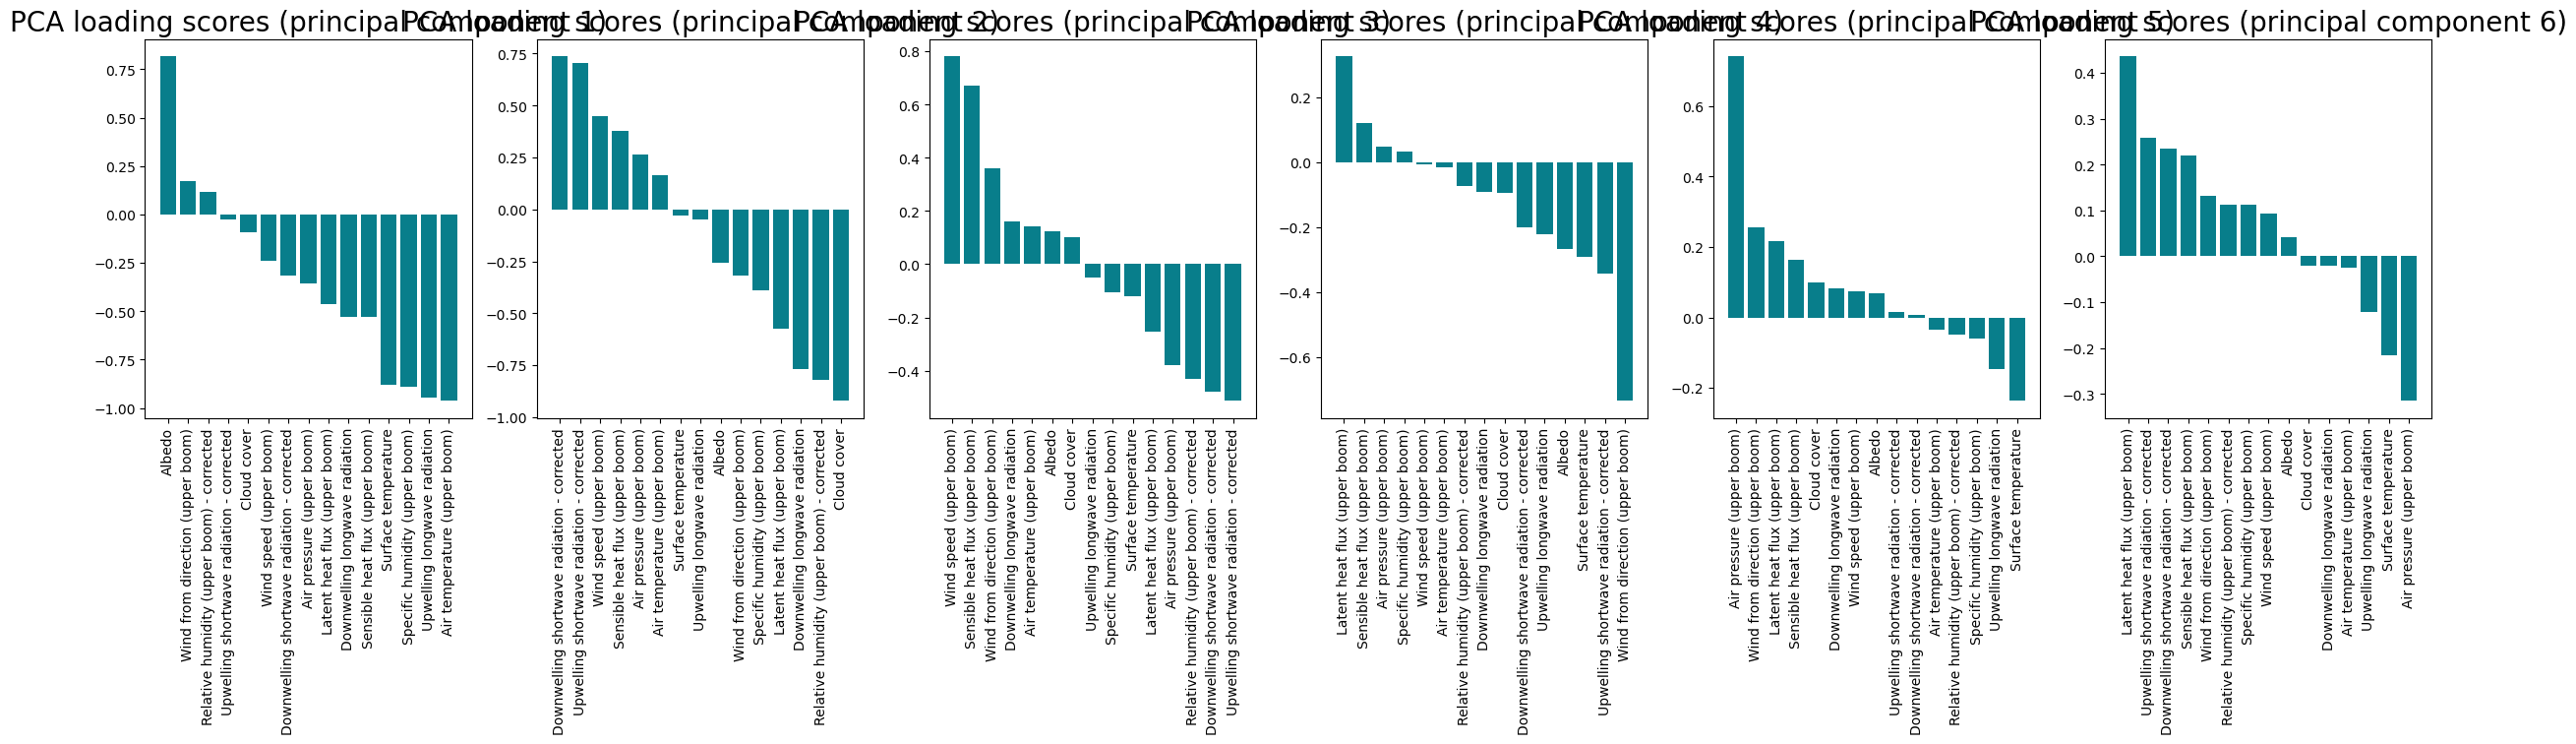

In [191]:



labels_vals = list(labels.values())
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns= labels_vals,
    index=  X_train[num_cols].columns
)

def plot_pca_loadings(labels_vals, loadings):
    fig, axes = plt.subplots(1, len(labels_vals), figsize=(len(labels_vals)*5, 5))

    for i, label in enumerate(labels_vals):
        pc_loadings = loadings.sort_values(by=label, ascending=False)[[label]]
        pc_loadings = pc_loadings.reset_index()
        pc_loadings.columns = ['Attribute', 'CorrelationWithPC{}'.format(i+1)]
        axes[i].bar(x=pc_loadings['Attribute'], height=pc_loadings['CorrelationWithPC{}'.format(i+1)], color='#087E8B')
        axes[i].set_title('PCA loading scores (principal component {})'.format(i+1), size=20)
        axes[i].tick_params(axis='x', rotation=90)

    plt.show()

plot_pca_loadings(labels_vals,loadings)
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.), 
    columns= labels_vals,
    index=  X_train[num_cols].columns
)
#pc1_loadings = loadings.sort_values(by=labels_vals[0], ascending=False)[[labels_vals[0]]]
#pc1_loadings = pc1_loadings.reset_index()
#pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

#plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
#plt.title('PCA loading scores (first principal component)', size=20)
#plt.xticks(rotation='vertical')
#plt.show()

-------------------------------- Without Imputation ---------------------------------------------------

In [48]:
#  We can follow this paper: https://www.sciencedirect.com/science/article/pii/S1574954121000261#:~:text=The%20standard%20algorithm%20of%20PCA%20is%20modified%20to%20accommodate%20incomplete%20data.&text=The%20method%20produces%20ordination%20scores%20for%20variables%20and%20observations%20simultaneously.&text=Information%20is%20maximally%20exhausted%2C%20while%20data%20imputation%20is%20not%20required.
# Or: https://github.com/allentran/pca-magic

import os

import numpy as np
from scipy.linalg import orth

class PPCA():

    def __init__(self):

        self.raw = None   # original data
        self.data = None  # standardized data
        self.C = None     # principal component matrix
        self.means = None # mean of data
        self.stds = None  # standard deviation of data
        self.eig_vals = None # eigenvalues of the covariance matrix

    def _standardize(self, X):
        """
        Internal function to standardize input data.

        Args:
            X (array): Input data to be standardized.

        Returns:
            array: Standardized data.
        """

        if self.means is None or self.stds is None:
            raise RuntimeError("Fit model first")

        return (X - self.means) / self.stds

    def fit(self, data, d=None, tol=1e-4, min_obs=10, verbose=False):
        """
        Fit the PPCA model to the input data.

        Args:
            data (array): Input data to fit the model.
            d (int, optional): Number of principal components to keep. Defaults to None, which is the same as the number of dimensions of the data.
            tol (float, optional): Tolerance for convergence. Defaults to 1e-4.
            min_obs (int, optional): Minimum number of observations required for a variable to be included in the model. Defaults to 10.
            verbose (bool, optional): Print the difference value for each iteration. Defaults to False.

        Raises:
            RuntimeError: If the model is not fit before calling _standardize function.

        Returns:
            None
        """

        self.raw = data
        self.raw[np.isinf(self.raw)] = np.max(self.raw[np.isfinite(self.raw)])

        valid_series = np.sum(~np.isnan(self.raw), axis=0) >= min_obs

        data = self.raw[:, valid_series].copy()
        N = data.shape[0]
        D = data.shape[1]

        self.means = np.nanmean(data, axis=0)
        self.stds = np.nanstd(data, axis=0)

        data = self._standardize(data)
        observed = ~np.isnan(data)
        missing = np.sum(~observed)
        data[~observed] = 0

        # initial

        if d is None:
            d = data.shape[1]
        
        if self.C is None:
            C = np.random.randn(D, d)
        else:
            C = self.C
        CC = np.dot(C.T, C)
        X = np.dot(np.dot(data, C), np.linalg.inv(CC))
        recon = np.dot(X, C.T)
        recon[~observed] = 0
        ss = np.sum((recon - data)**2)/(N*D - missing)

        v0 = np.inf
        counter = 0

        while True:

            Sx = np.linalg.inv(np.eye(d) + CC/ss)

            # e-step
            ss0 = ss
            if missing > 0:
                proj = np.dot(X, C.T)
                data[~observed] = proj[~observed]
            X = np.dot(np.dot(data, C), Sx) / ss

            # m-step
            XX = np.dot(X.T, X)
            C = np.dot(np.dot(data.T, X), np.linalg.pinv(XX + N*Sx))
            CC = np.dot(C.T, C)
            recon = np.dot(X, C.T)
            recon[~observed] = 0
            ss = (np.sum((recon-data)**2) + N*np.sum(CC*Sx) + missing*ss0)/(N*D)

            # calc diff for convergence
            det = np.log(np.linalg.det(Sx))
            if np.isinf(det):
                det = abs(np.linalg.slogdet(Sx)[1])
            v1 = N*(D*np.log(ss) + np.trace(Sx) - det) \
                + np.trace(XX) - missing*np.log(ss0)
            diff = abs(v1/v0 - 1)
            if verbose:
                print(diff)
            if (diff < tol) and (counter > 5):
                break

            counter += 1
            v0 = v1


        C = orth(C)
        vals, vecs = np.linalg.eig(np.cov(np.dot(data, C).T))
        order = np.flipud(np.argsort(vals))
        vecs = vecs[:, order]
        vals = vals[order]

        C = np.dot(C, vecs)

        # attach objects to class
        self.C = C
        self.data = data
        self.eig_vals = vals
        self._calc_var()

    def transform(self, data=None):

        if self.C is None:
            raise RuntimeError('Fit the data model first.')
        if data is None:
            return np.dot(self.data, self.C)
        return np.dot(data, self.C)

    def _calc_var(self):

        if self.data is None:
            raise RuntimeError('Fit the data model first.')

        data = self.data.T

        # variance calc
        var = np.nanvar(data, axis=1)
        total_var = var.sum()
        self.var_exp = self.eig_vals.cumsum() / total_var

    def save(self, fpath):

        np.save(fpath, self.C)
        
    def load(self, fpath):

        assert os.path.isfile(fpath)

        self.C = np.load(fpath)

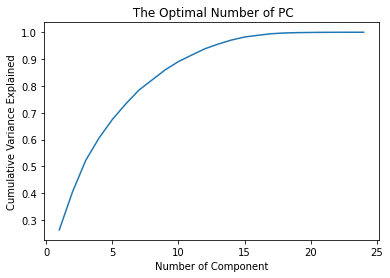

In [49]:
ppca = PPCA()

ppca.fit(data = X_train.to_numpy(), d=30)

# visualizing the amount of variance data explained for each principle component
cumulative_variance_explained = ppca.var_exp
x_values = list(range(1, len(cumulative_variance_explained)+1))

#plot the line graph explaining variance of feature variables through the components
plt.plot(x_values, cumulative_variance_explained)
plt.xlabel('Number of Component')
plt.ylabel('Cumulative Variance Explained')
plt.title(' The Optimal Number of PC')
plt.show()


Text(0.5, 1.0, 'Correlation Heatmap')

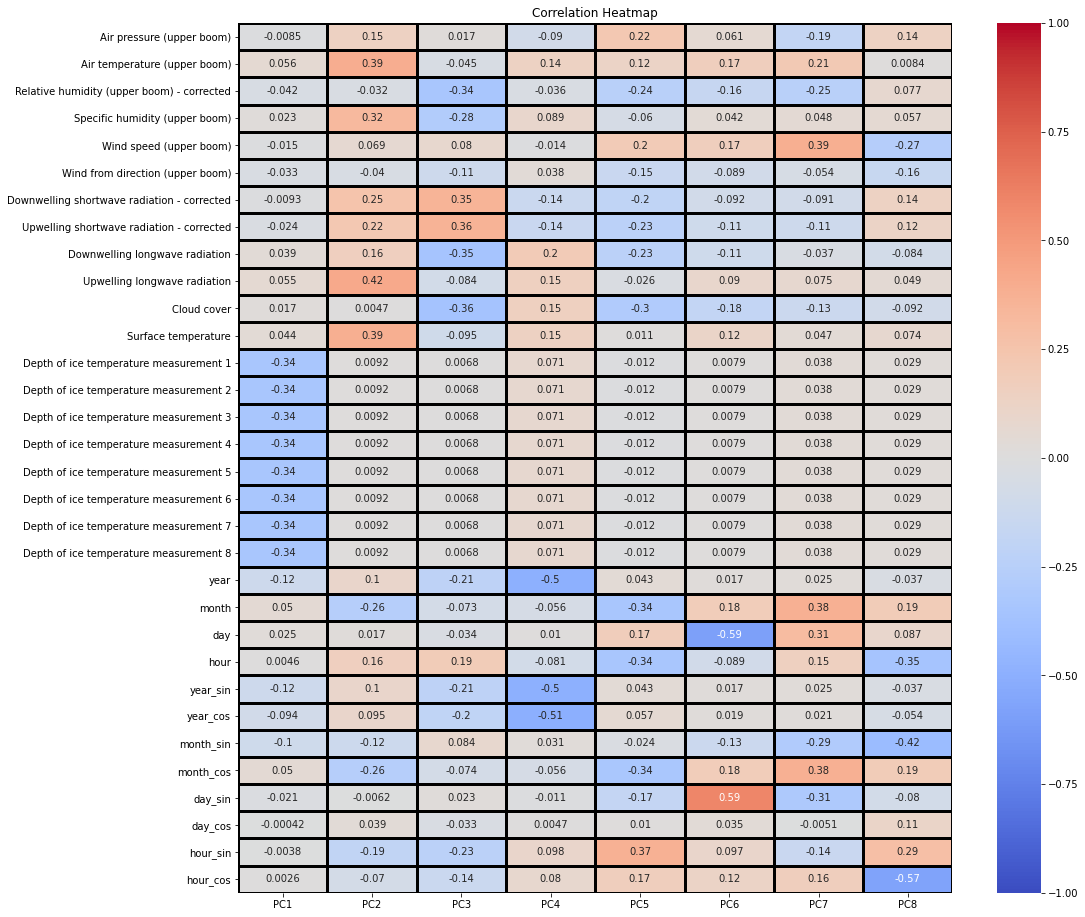

In [54]:
#Identify the optimal number of principal components 
optimal_component = np.argmax(cumulative_variance_explained >=0.8) + 1

columns = [f'PC{i}' for i in range(1, optimal_component + 1)]

ppca = PPCA()

X_train_ppca = ppca.fit(data = X_train.to_numpy(), d=optimal_component) 
X_train_ppca = ppca.transform(X_train_ppca)
X_test_ppca = ppca.transform(X_test.to_numpy())

# see how much features contribute to which components
ppca_df = pd.DataFrame(ppca.C,
                       columns = columns,
                       index =X_train.columns)
ppca_df.head()

#plot a heatmap to visualise how the feature variables contribute to PC
# Heatmap
plt.figure(figsize=(16, 16))

heatmap = sns.heatmap(ppca_df, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')

heatmap.set_title('Correlation Heatmap')
